In [14]:
# Install required libraries (if needed)
# No specific pip for RF

# Import libraries for RF
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Upload dataset
from google.colab import files
uploaded = files.upload()

# Load the data
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Optional: Subsample for faster execution (uncomment if needed)
# df = df.sample(frac=0.2, random_state=42)

# Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df.drop('Date', axis=1, inplace=True)

X = df.drop('RainTomorrow', axis=1)
y = LabelEncoder().fit_transform(df['RainTomorrow'])

categorical_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
binary_cat = ['RainToday']
numerical_cols = [col for col in X.columns if col not in categorical_cols + binary_cat]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('bin', OneHotEncoder(drop='first', sparse_output=False), binary_cat)
    ])

X_processed = preprocessor.fit_transform(X)

feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out()) + list(preprocessor.named_transformers_['bin'].get_feature_names_out())

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, stratify=y, random_state=42)

Saving Weather Data Set.csv to Weather Data Set (3).csv


In [16]:
# Member 4: Random Forest code
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [10, None], 'class_weight': ['balanced', None]}
grid_rf = RandomizedSearchCV(rf, param_grid_rf, n_iter=6, cv=StratifiedKFold(n_splits=3), scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print(f'Best Params: {grid_rf.best_params_}')
best_rf = grid_rf.best_estimator_

Best Params: {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}


CV Accuracy: 0.7960 ± 0.0018
Accuracy: 0.7924
F1: 0.6126
Precision: 0.5182
Recall: 0.7490
AUC: 0.8616


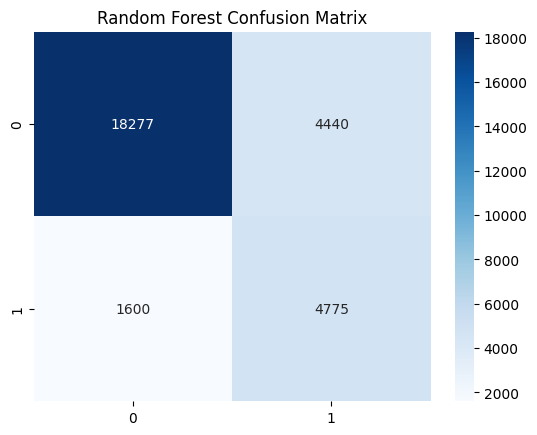

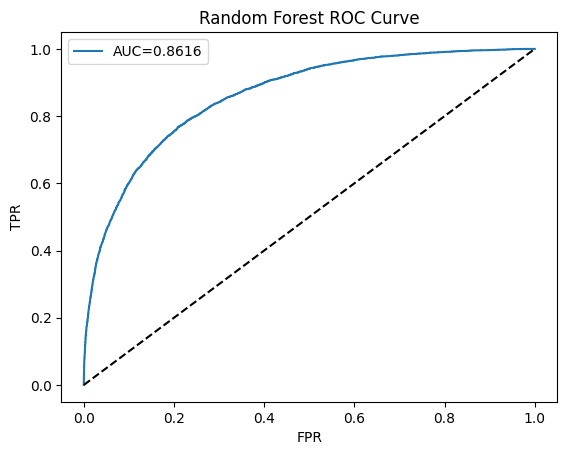

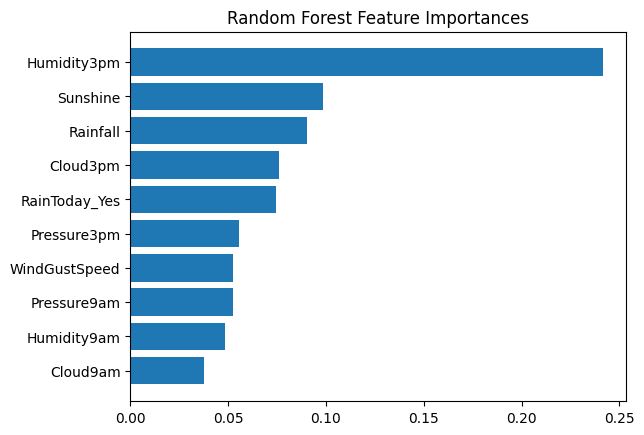

In [17]:
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=3, scoring='accuracy')
print(f'CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

y_pred_rf = best_rf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}')
print(f'F1: {f1_score(y_test, y_pred_rf):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_rf):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_rf):.4f}')
print(f'AUC: {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]):.4f}')

cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, best_rf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f'AUC={roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]):.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.title('Random Forest ROC Curve')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend()
plt.show()

importances = best_rf.feature_importances_
sorted_idx = np.argsort(importances)[-10:]
plt.barh(range(10), importances[sorted_idx])
plt.yticks(range(10), [feature_names[i] for i in sorted_idx])
plt.title('Random Forest Feature Importances')
plt.show()